In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os.path

In [2]:
CTW_labelled = "E:/dataset/CTW2020_labelled_data/"   # the folder contains the data from “IEEE CTW 2020 Challenge,” https://data.ieeemlc.org/Ds4Detail, 2020.

In [3]:
def get_data(data_file):
    
    f = h5py.File(data_file, 'r')
    H_Re = f['H_Re'][:] #shape (sample size, 56, 924, 5)
    H_Im = f['H_Im'][:] #shape (sample size, 56, 924, 5)
    SNR = f['SNR'][:] #shape (sample size, 56, 5)
    Pos = f['Pos'][:] #shape(sample size, 3)
    f.close()
            
    return H_Re, H_Im, SNR, Pos        

In [4]:
### example code to load data from file_1.hdf4  ###
Ns  = np.array([512, 512, 512, 512, 512, 512, 512, 512, 883])
NN  = np.sum(Ns) 
Imgs=[] 
SNRs=[]
XYs =[]
for i in range(1,10):
    data_file = CTW_labelled+"file_"+str(i)+".hdf5"
    #print(data_file)
    H_Re, H_Im, SNR, Pos = get_data(data_file)
    H = H_Re + np.complex('j')*H_Im
    s = H_Re.shape
    N = s[0]
    A = s[1]
    F = s[2]
    M = s[3]
    print('Number of samples in file = ', N)
    Cs = np.array(np.zeros((N,M,A,A)))
    for n in range(0,N):
        for m in range(0,M):
            h = H[n,:,:,m]
            C = np.matmul(h,h.conj().transpose())
            Cu= np.real(np.triu(C,k= 0))
            Cl= np.imag(np.tril(C,k=-1))
            Cs[n,m,:,:] = Cu+Cl
    if i==1: 
        SNRs = SNR
        XYs  = Pos
        CSIs = Cs
    else:
        SNRs = np.vstack((SNRs,SNR))
        XYs  = np.vstack((XYs ,Pos))
        CSIs = np.vstack((CSIs,Cs )) 
    #print("Imgs is of shape {}".format(Imgs.shape))

print("H_Re is of shape {}".format(H_Re.shape))
print("CSIs is of shape {}".format(CSIs.shape))
print("SNRs is of shape {}".format(SNRs.shape))
print("XYs  is of shape {}".format(XYs.shape ))
np.save("SNRs.npy",SNRs)
np.save("XYs.npy" ,XYs )
#np.save("CSIs.npy",CSIs)
print('files saved!')

C:\Users\Neil\AppData\Local\Temp/ipykernel_39512/188280191.py:11: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  H = H_Re + np.complex('j')*H_Im


Number of samples in file =  512
Number of samples in file =  512
Number of samples in file =  512
Number of samples in file =  512
Number of samples in file =  512
Number of samples in file =  512
Number of samples in file =  512
Number of samples in file =  512
Number of samples in file =  883
H_Re is of shape (883, 56, 924, 5)
CSIs is of shape (4979, 5, 56, 56)
SNRs is of shape (4979, 56, 5)
XYs  is of shape (4979, 3)
files saved!


In [5]:
DistMatrix = np.zeros((NN,NN))
for i in range(0,NN):
    for j in range(i+1,NN):
        xyi  = XYs[i,0:2]
        xyj  = XYs[j,0:2]
        dxy  = xyi-xyj
        dist = dxy[0]**2+dxy[1]**2
        dist = dist**(1/2)
        DistMatrix[i,j] = dist
DistMatrix = np.transpose(DistMatrix) +DistMatrix
DistMatrix = DistMatrix.astype(np.float16)
print(DistMatrix.dtype)
np.save('DistMatrix_16bits.npy',DistMatrix)

float16


<function matplotlib.pyplot.show(close=None, block=None)>

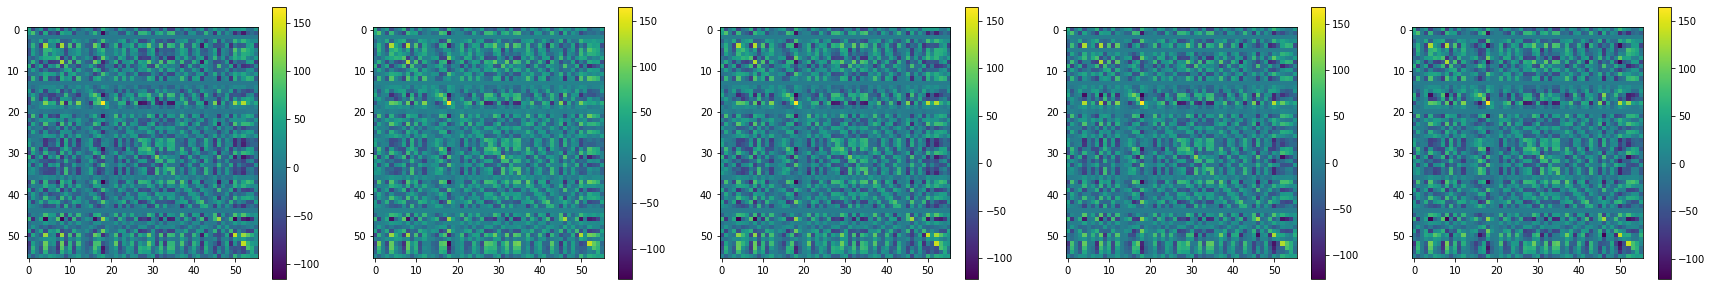

In [6]:
Imagindex = 89
plt.figure(figsize=(30,5))
for m in range(1,M+1):
    plt.subplot(1,M,m)
    Img= CSIs[Imagindex,m-1,:,:]
    plt.imshow(Img)
    plt.colorbar()
plt.show

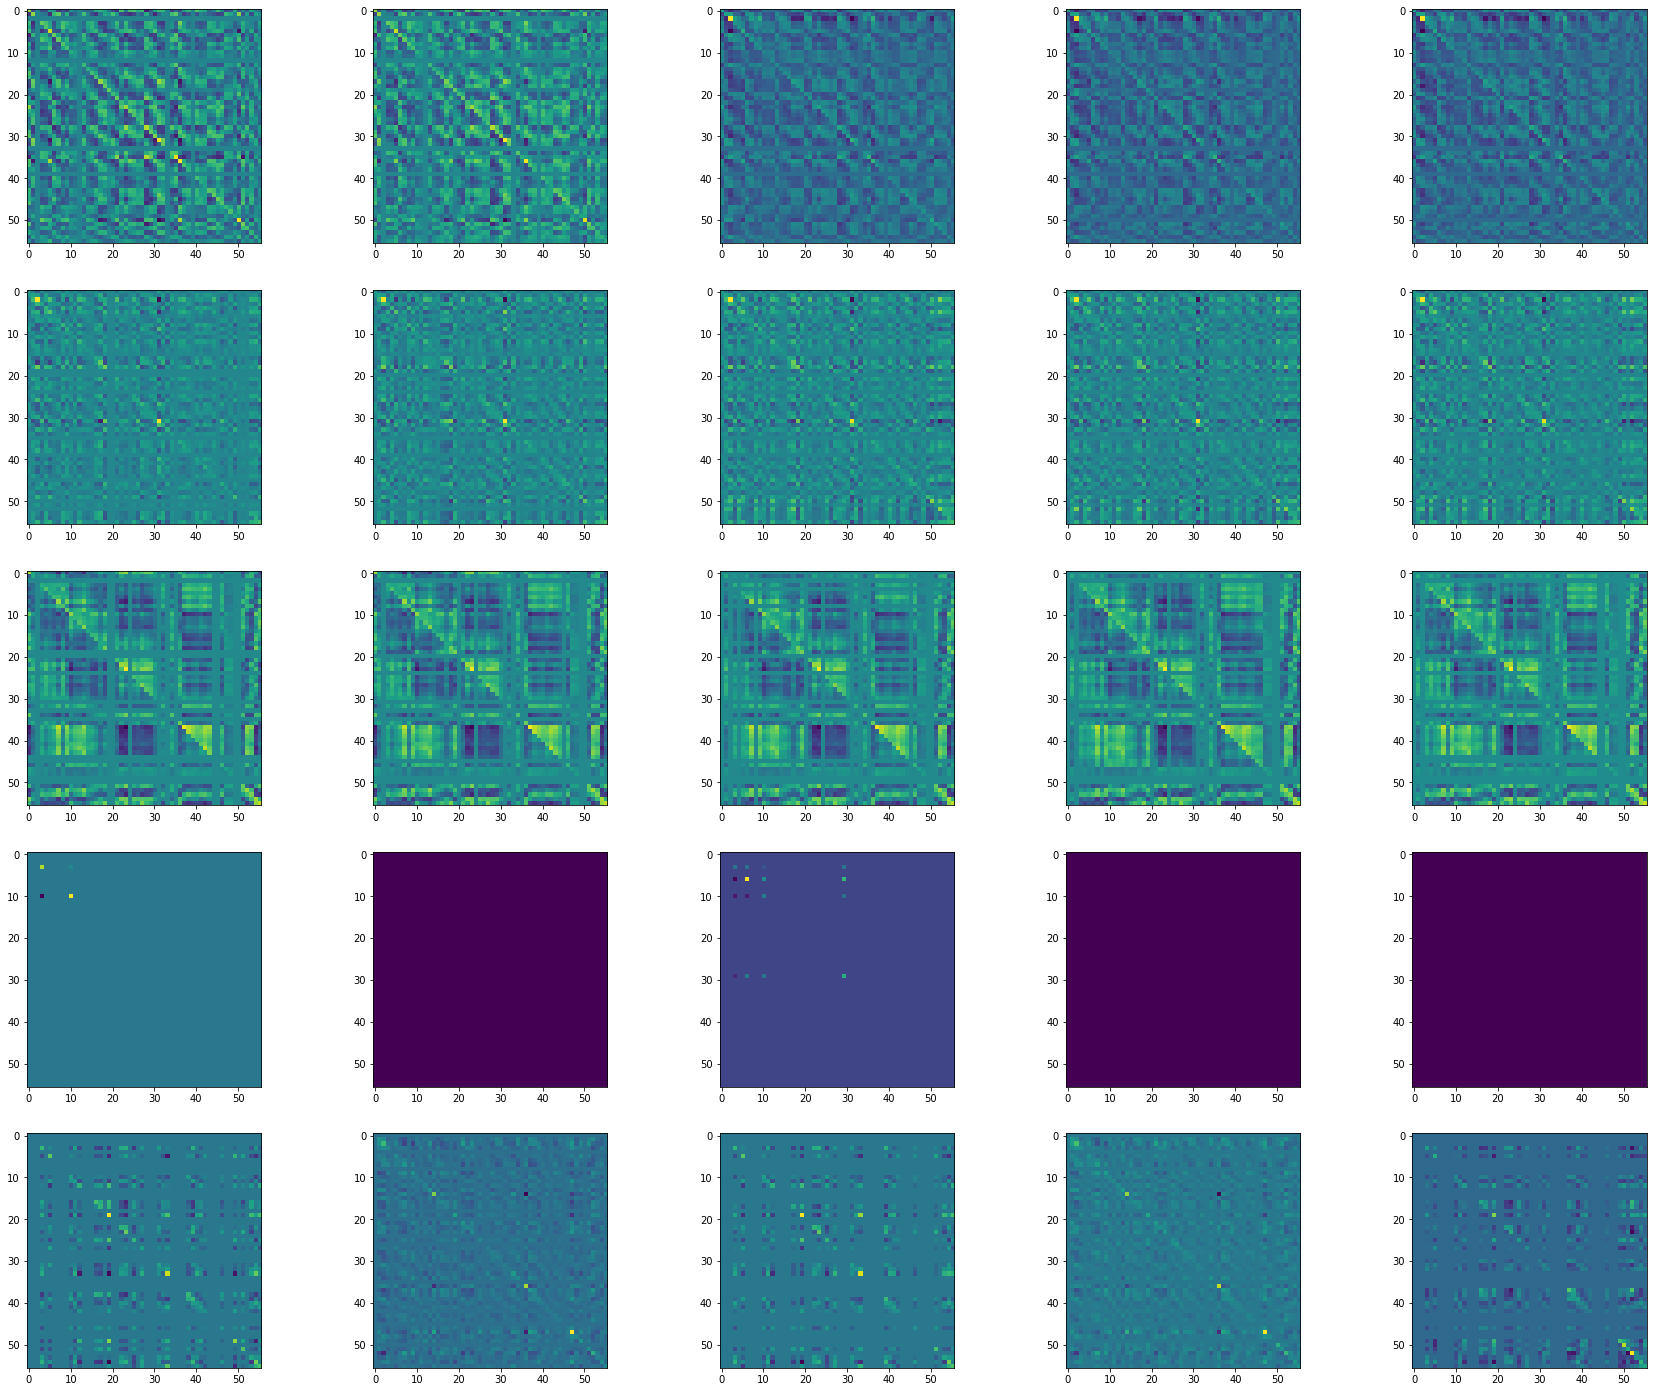

In [7]:
index = np.argsort(DistMatrix[Imagindex,:])
ds = DistMatrix[Imagindex,index]
Kp = 2
Kn = 2
import random
samplesIndexs = []
samplesIndexs.append(Imagindex)
for i in range(0,Kp):
    samplesIndexs.append(index[i+1,].astype(int))
for i in range(0,Kn):
    samplesIndexs.append(random.randint(0,NN-1))

plt.figure(figsize=(30,5*5))
for ii in range(0,Kp+Kn+1):
    i = samplesIndexs[ii]
    for m in range(0,M):
        plt.subplot(Kp+Kn+1,M,m+ii*M+1)
        Img = CSIs[ii,m,::]
        plt.imshow(Img)

In [8]:
CSIs_used = np.zeros((NN,A,A))
for i in range(0,NN):
    snr_ants = SNRs[i,:,:]
    snr_maxs = np.max(snr_ants,axis=0)
    measurement_used = np.argmax(snr_maxs)   # for each location, there are five measurements, we use the measurement with best SNR
    CSIs_used[i,:,:] = CSIs[i,measurement_used,:,:]
np.save('CSIs_used.npy',CSIs_used)